In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from skopt import BayesSearchCV
from scipy.stats import ttest_ind, ttest_rel,chisquare
from imblearn.over_sampling import SMOTENC

from collections import namedtuple, Counter
from itertools import combinations
from recordtype import recordtype
import pickle

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)


In [2]:
SEED = 0
JOBS = 10

In [3]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Cleaning

In [4]:
train_transaction = df.read_csv('./data/train_transaction.csv').set_index('TransactionID')
train_identity = df.read_csv('./data/train_identity.csv').set_index('TransactionID')

In [5]:
train_transaction.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [6]:
train_identity.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 40 entries, id_01 to DeviceInfo
dtypes: object(17), float64(23)

In [7]:
X_train = train_transaction.join(train_identity, how='left')

In [14]:
X_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 433 entries, isFraud to DeviceInfo
dtypes: object(31), float64(399), int64(3)

In [9]:
X_train.to_csv('./data/X_train/*.csv', index=True, header=True)

['/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/00.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/01.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/02.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/03.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/04.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/05.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/06.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/07.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/08.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/09.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/10.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_train/11.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_t

In [11]:
test_transaction = df.read_csv('./data/test_transaction.csv').set_index('TransactionID')
test_identity = df.read_csv('./data/test_identity.csv').set_index('TransactionID')

In [12]:
test_transaction.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 392 entries, TransactionDT to V339
dtypes: object(14), float64(376), int64(2)

In [13]:
test_identity.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 40 entries, id-01 to DeviceInfo
dtypes: object(17), float64(23)

In [15]:
X_test = test_transaction.join(test_identity, how='left')

In [16]:
X_test.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: object(31), float64(399), int64(2)

In [18]:
[column for column in X_test.columns if column not in X_train.columns]

['id-01',
 'id-02',
 'id-03',
 'id-04',
 'id-05',
 'id-06',
 'id-07',
 'id-08',
 'id-09',
 'id-10',
 'id-11',
 'id-12',
 'id-13',
 'id-14',
 'id-15',
 'id-16',
 'id-17',
 'id-18',
 'id-19',
 'id-20',
 'id-21',
 'id-22',
 'id-23',
 'id-24',
 'id-25',
 'id-26',
 'id-27',
 'id-28',
 'id-29',
 'id-30',
 'id-31',
 'id-32',
 'id-33',
 'id-34',
 'id-35',
 'id-36',
 'id-37',
 'id-38']

In [21]:
X_test.to_csv('./data/X_test/*.csv', index=True, header=X_train.columns.drop('isFraud'))

['/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/00.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/01.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/02.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/03.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/04.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/05.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/06.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/07.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/08.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/09.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/X_test/10.csv']

# Sampling

In [43]:
types={'DeviceInfo': 'object',
       'DeviceType': 'object',
       'R_emaildomain': 'object',
       'id_12': 'object',
       'id_15': 'object',
       'id_16': 'object',
       'id_28': 'object',
       'id_29': 'object',
       'id_31': 'object',
       'id_35': 'object',
       'id_36': 'object',
       'id_37': 'object',
       'id_38': 'object',
       'id_23': 'object',
       'id_27': 'object',
       'id_30': 'object',
       'id_33': 'object',
       'id_34': 'object'}

In [5]:
X_train = df.read_csv('./data/X_train/*.csv', dtype=types).set_index('TransactionID')

In [6]:
X_train['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

In [7]:
X_train_pos = X_train.loc[X_train['isFraud']==1]
X_train_neg = X_train.loc[X_train['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [8]:
X_train_sample = df.concat([X_train_pos, X_train_neg])

In [9]:
X_train_sample = X_train_sample.compute()

In [15]:
X_train_sample.to_csv('./data/X_train_sample.csv', index=True, header=True) 

In [44]:
X_test = df.read_csv('./data/X_test/*.csv', dtype=types).set_index('TransactionID')

In [45]:
X_test_sample = X_test.sample(frac=0.1, random_state=SEED)

In [46]:
X_test_sample = X_test_sample.compute()

In [47]:
X_test_sample.to_csv('./data/X_test_sample.csv', index=True, header=True)

# Sample Exploration

In [48]:
X_train_sample = pandas.read_csv('./data/X_train_sample.csv', header=0).set_index('TransactionID')
X_test_sample = pandas.read_csv('./data/X_test_sample.csv', header=0).set_index('TransactionID')

In [49]:
X_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 2987203 to 3560507
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 162.8+ MB


In [50]:
X_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50669 entries, 3663571 to 4158873
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 167.4+ MB


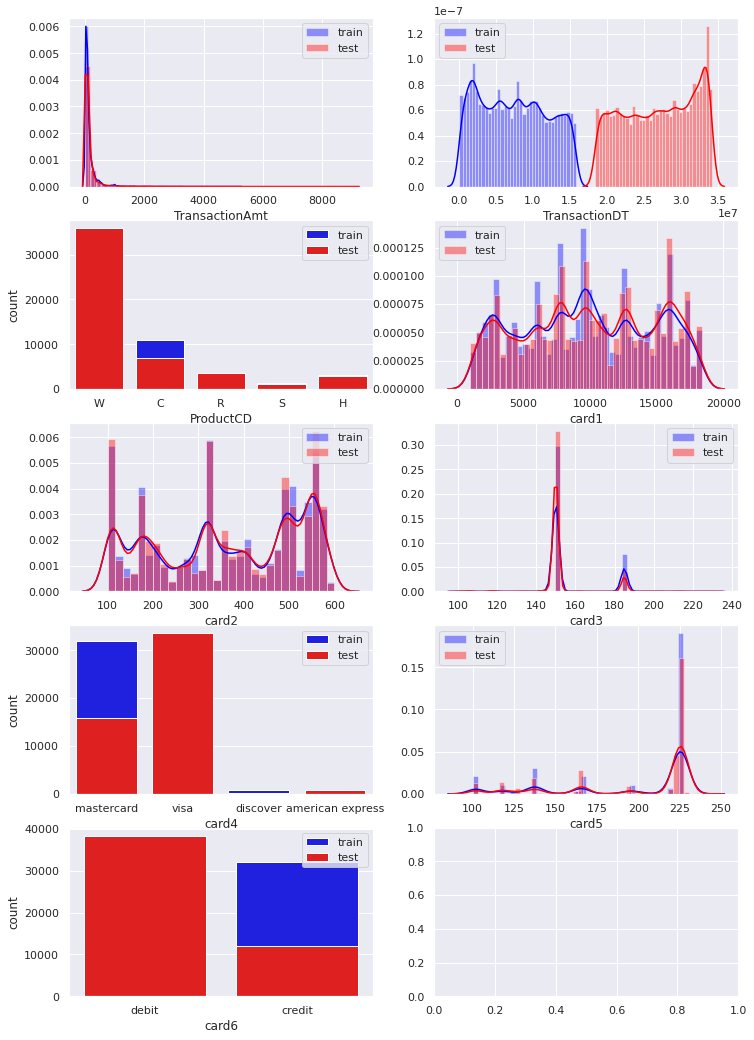

In [51]:
f,ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 18))
sns.distplot(X_train_sample['TransactionAmt'], color='blue', ax=ax[0,0], label='train')
sns.distplot(X_test_sample['TransactionAmt'], color='red', ax=ax[0,0], label='test')
ax[0, 0].legend()
sns.distplot(X_train_sample['TransactionDT'], color='blue', ax=ax[0,1], label='train')
sns.distplot(X_test_sample['TransactionDT'], color='red', ax=ax[0,1], label='test')
ax[0, 1].legend()
sns.countplot(X_train_sample['ProductCD'], color='blue', ax=ax[1,0], label='train')
sns.countplot(X_test_sample['ProductCD'], color='red', ax=ax[1,0], label='test')
ax[1, 0].legend()
sns.distplot(X_train_sample['card1'], color='blue', ax=ax[1,1], label='train')
sns.distplot(X_test_sample['card1'], color='red', ax=ax[1,1], label='test')
ax[1, 1].legend()
sns.distplot(X_train_sample['card2'], color='blue', ax=ax[2,0], label='train')
sns.distplot(X_test_sample['card2'], color='red', ax=ax[2,0], label='test')
ax[2, 0].legend()
sns.distplot(X_train_sample['card3'], color='blue', ax=ax[2,1], label='train')
sns.distplot(X_test_sample['card3'], color='red', ax=ax[2,1], label='test')
ax[2, 1].legend()
sns.countplot(X_train_sample['card4'], color='blue', ax=ax[3,0], label='train')
sns.countplot(X_test_sample['card4'], color='red', ax=ax[3,0], label='test')
ax[3, 0].legend()
sns.distplot(X_train_sample['card5'], color='blue', ax=ax[3,1], label='train')
sns.distplot(X_test_sample['card5'], color='red', ax=ax[3,1], label='test')
ax[3, 1].legend()
sns.countplot(X_train_sample['card6'], color='blue', ax=ax[4,0], label='train')
sns.countplot(X_test_sample['card6'], color='red', ax=ax[4,0], label='test')
ax[4, 0].legend()
plt.show()

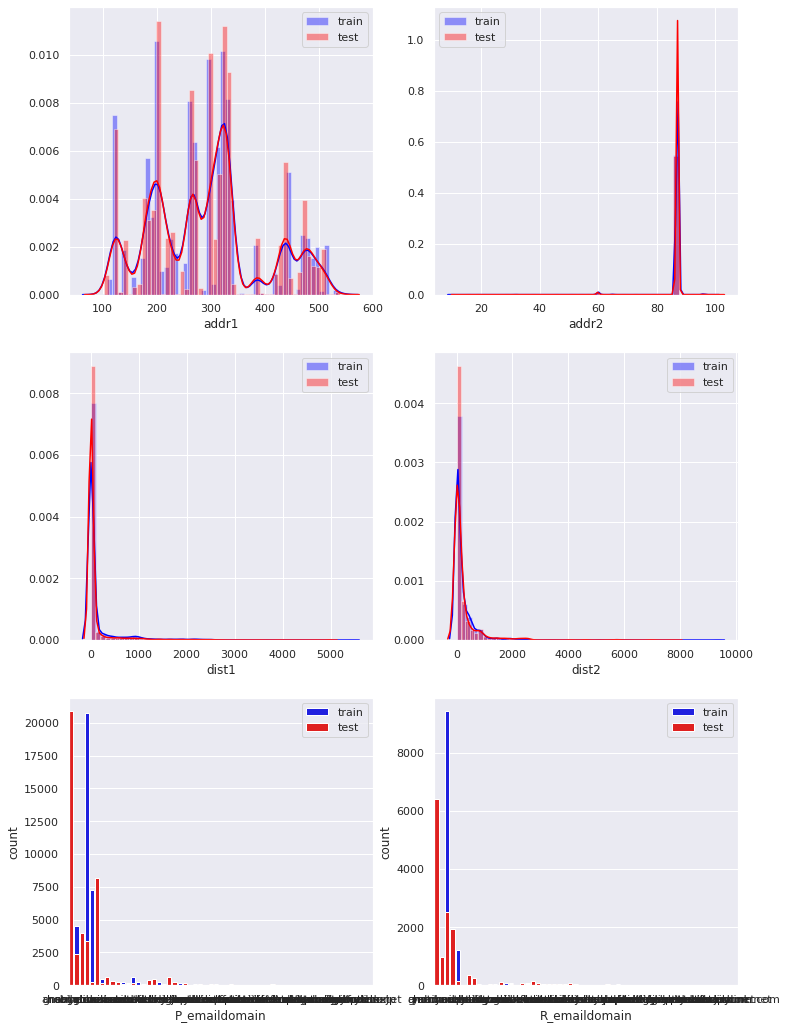

In [52]:
f,ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))
sns.distplot(X_train_sample['addr1'], color='blue', ax=ax[0,0], label='train')
sns.distplot(X_test_sample['addr1'], color='red', ax=ax[0,0], label='test')
ax[0, 0].legend()
sns.distplot(X_train_sample['addr2'], color='blue', ax=ax[0,1], label='train')
sns.distplot(X_test_sample['addr2'], color='red', ax=ax[0,1], label='test')
ax[0, 1].legend()
sns.distplot(X_train_sample['dist1'], color='blue', ax=ax[1,0], label='train')
sns.distplot(X_test_sample['dist1'], color='red', ax=ax[1,0], label='test')
ax[1, 0].legend()
sns.distplot(X_train_sample['dist2'], color='blue', ax=ax[1,1], label='train')
sns.distplot(X_test_sample['dist2'], color='red', ax=ax[1,1], label='test')
ax[1, 1].legend()
sns.countplot(X_train_sample['P_emaildomain'], color='blue', ax=ax[2,0], label='train')
sns.countplot(X_test_sample['P_emaildomain'], color='red', ax=ax[2,0], label='test')
ax[2, 0].legend()
sns.countplot(X_train_sample['R_emaildomain'], color='blue', ax=ax[2,1], label='train')
sns.countplot(X_test_sample['R_emaildomain'], color='red', ax=ax[2,1], label='test')
ax[2, 1].legend()
plt.show()

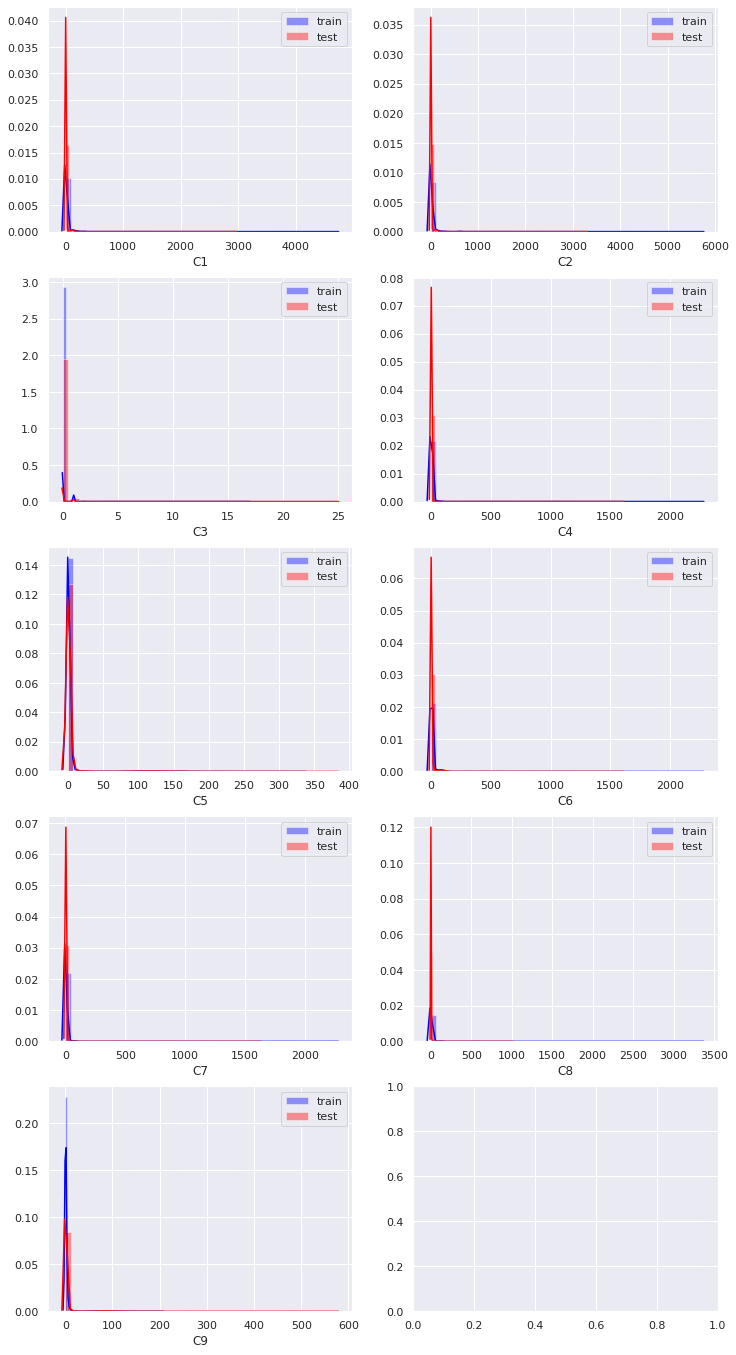

In [53]:
f,ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))
idx=1
for row in range(0, 5):
    for col in range(0, 2):
        if idx<10:
            sns.distplot(X_train_sample[f'C{idx}'], color='blue', ax=ax[row,col], label='train')
            sns.distplot(X_test_sample[f'C{idx}'], color='red', ax=ax[row,col], label='test')
            ax[row, col].legend()
            idx+=1
plt.show()

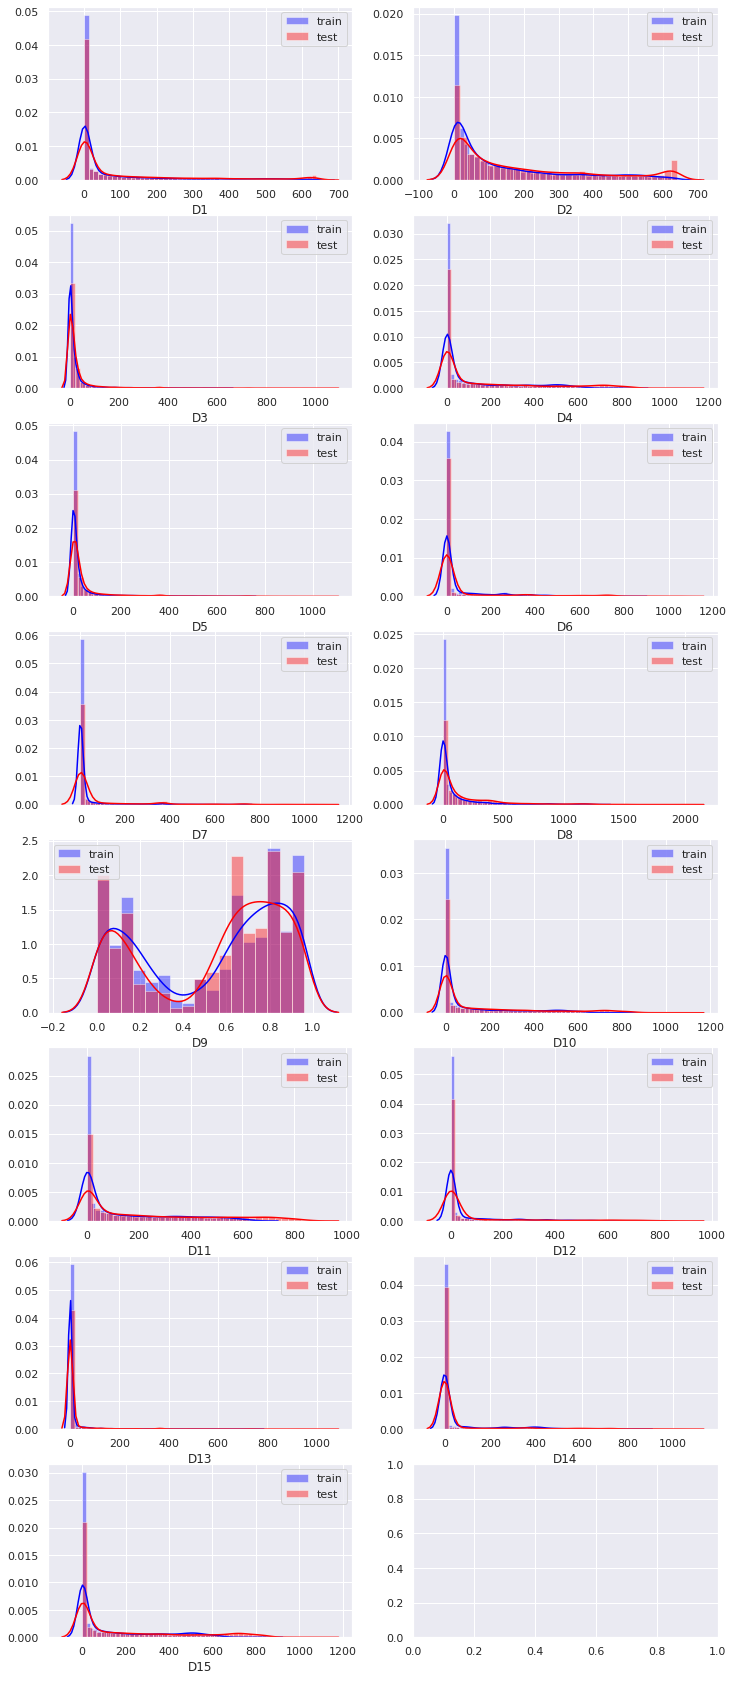

In [55]:
f,ax = plt.subplots(nrows=8, ncols=2, figsize=(12, 30))
idx=1
for row in range(0, 8):
    for col in range(0, 2):
        if idx<16:
            sns.distplot(X_train_sample[f'D{idx}'], color='blue', ax=ax[row,col], label='train')
            sns.distplot(X_test_sample[f'D{idx}'], color='red', ax=ax[row,col], label='test')
            ax[row, col].legend()
            idx+=1
plt.show()

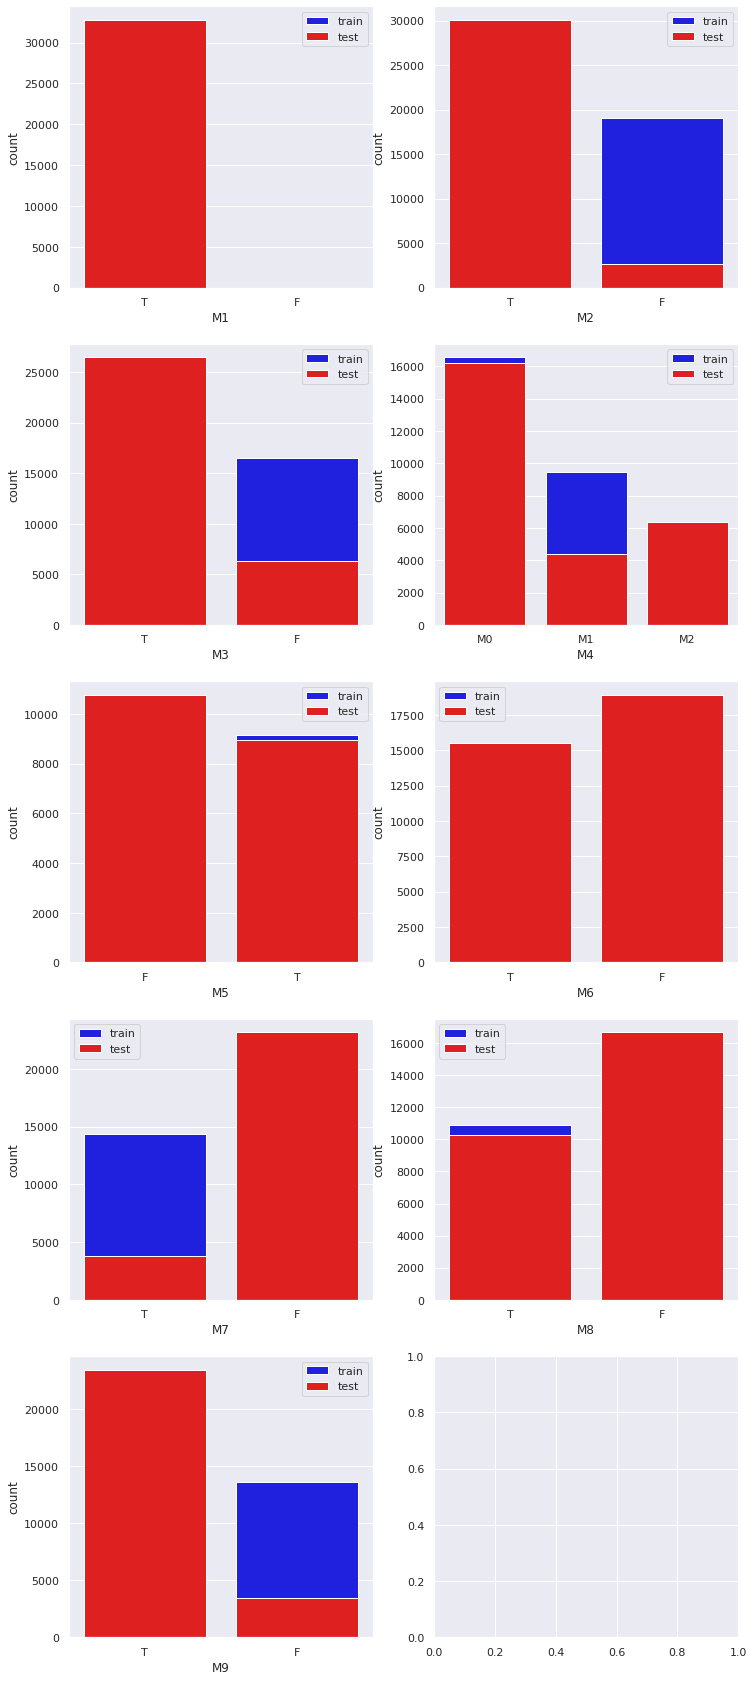

In [56]:
f,ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
idx=1
for row in range(0, 5):
    for col in range(0, 2):
        if idx<10:
            sns.countplot(X_train_sample[f'M{idx}'], color='blue', ax=ax[row,col], label='train')
            sns.countplot(X_test_sample[f'M{idx}'], color='red', ax=ax[row,col], label='test')
            ax[row, col].legend()
            idx+=1
plt.show()

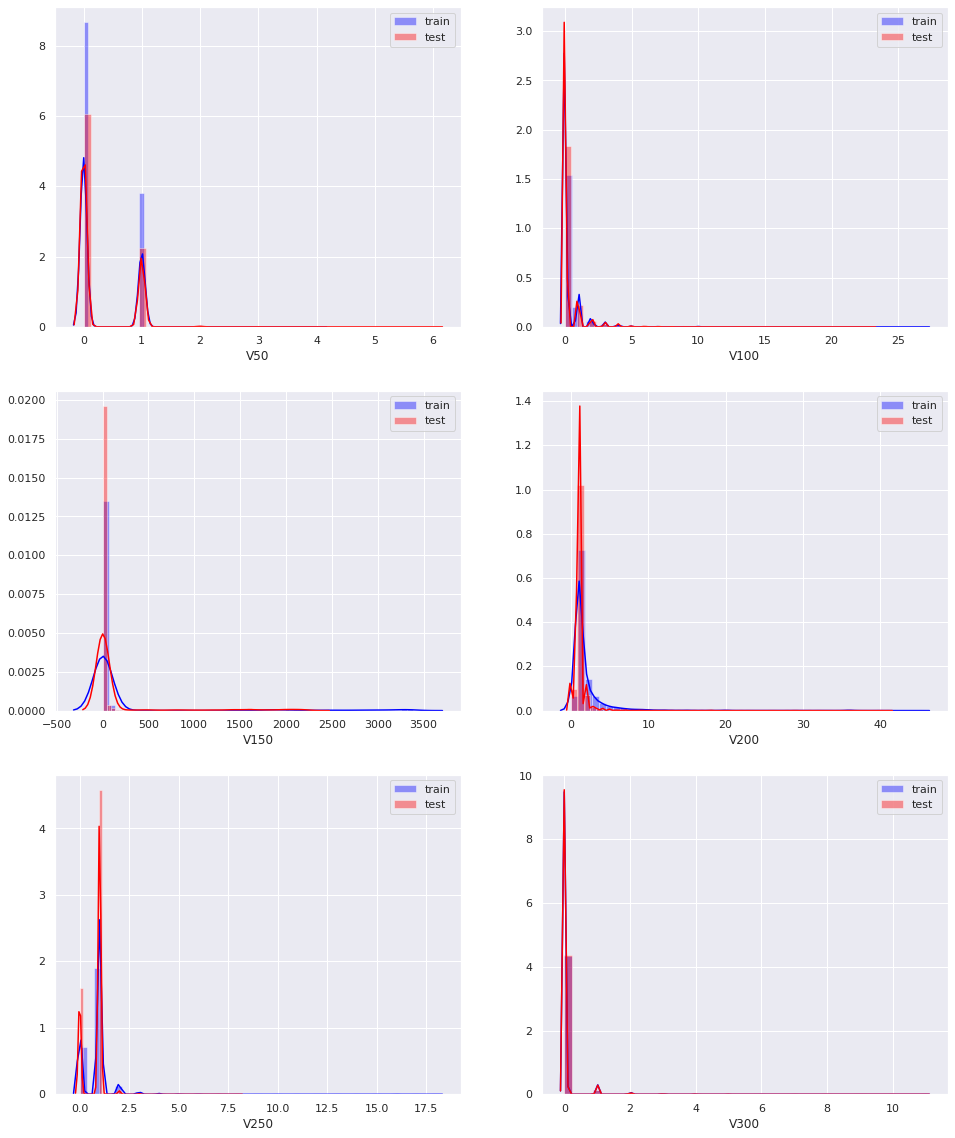

In [61]:
f,ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 20))
idx=50
for row in range(0, 5):
    for col in range(0, 2):
        if idx<340:
            sns.distplot(X_train_sample[f'V{idx}'], color='blue', ax=ax[row,col], label='train')
            sns.distplot(X_test_sample[f'V{idx}'], color='red', ax=ax[row,col], label='test')
            ax[row, col].legend()
            idx+=50
plt.show()

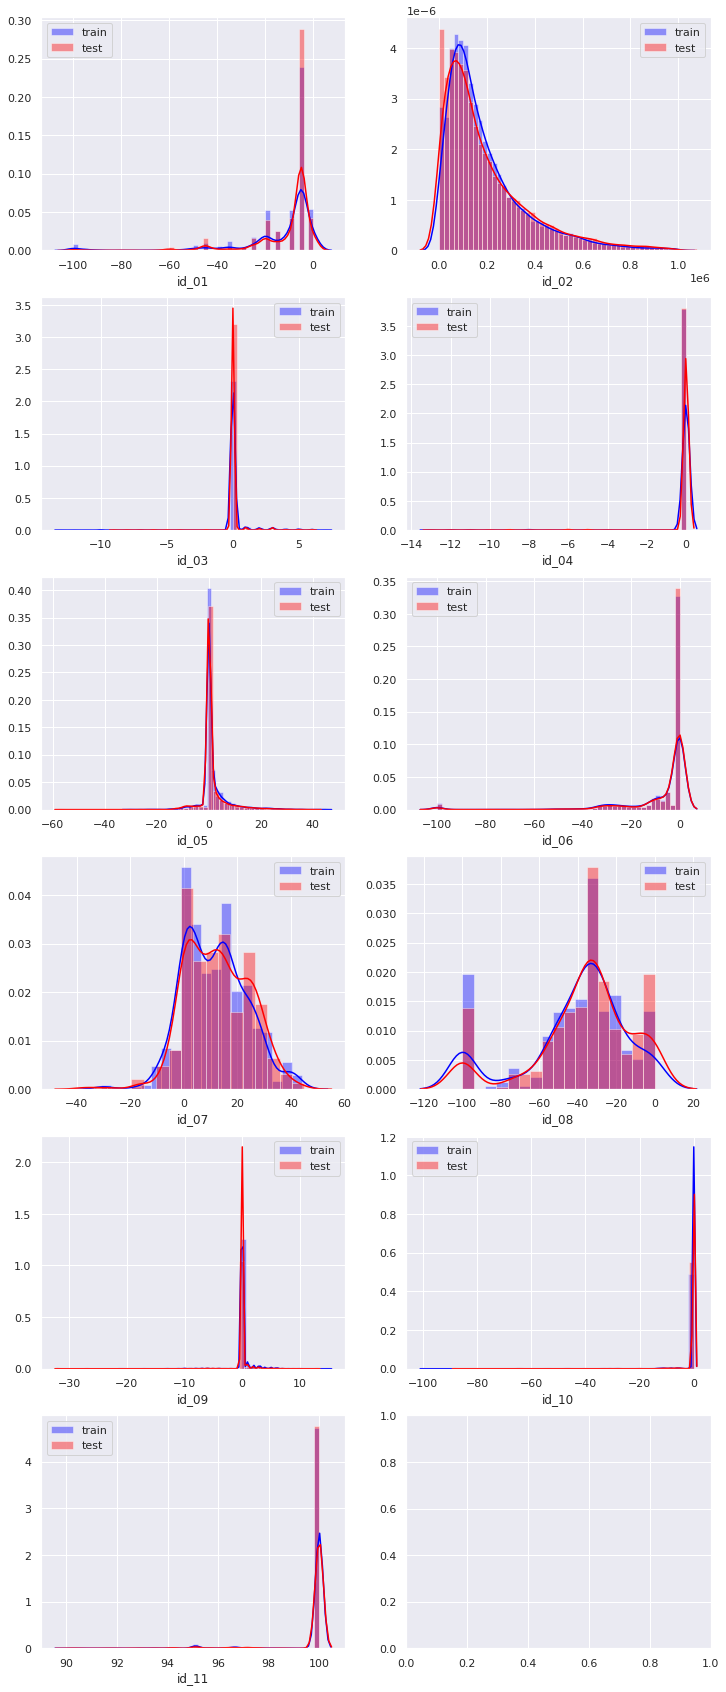

In [65]:
f,ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 30))
idx=1
for row in range(0, 6):
    for col in range(0, 2):
        if idx<12:
            if idx<10:
                sns.distplot(X_train_sample[f'id_0{idx}'], color='blue', ax=ax[row,col], label='train')
                sns.distplot(X_test_sample[f'id_0{idx}'], color='red', ax=ax[row,col], label='test')
            else:
                sns.distplot(X_train_sample[f'id_{idx}'], color='blue', ax=ax[row,col], label='train')
                sns.distplot(X_test_sample[f'id_{idx}'], color='red', ax=ax[row,col], label='test')
            ax[row, col].legend()
            idx+=1
        
plt.show()

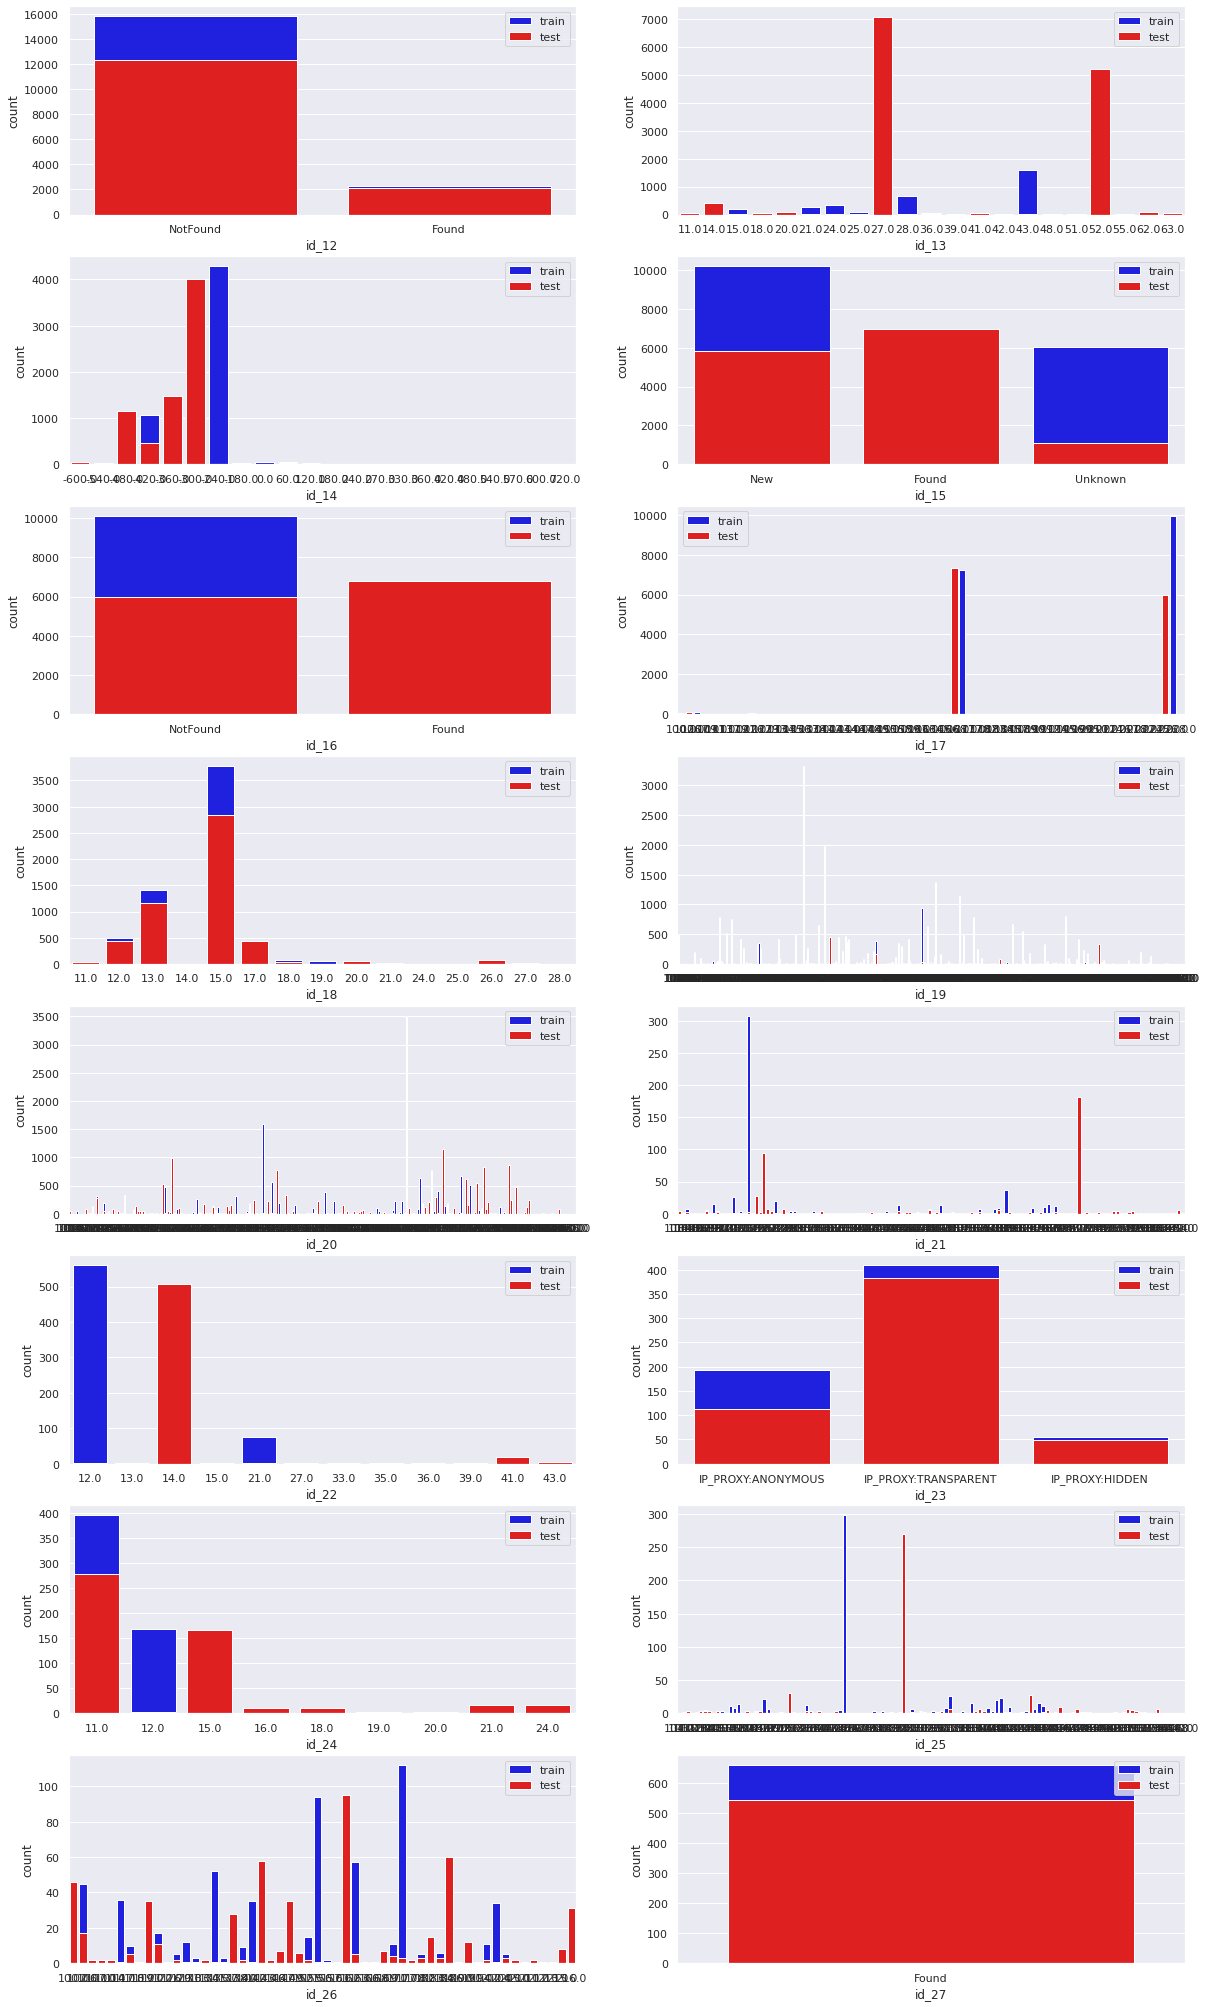

In [68]:
f,ax = plt.subplots(nrows=8, ncols=2, figsize=(20, 36))
idx=12
for row in range(0, 8):
    for col in range(0, 2):
        sns.countplot(X_train_sample[f'id_{idx}'], color='blue', ax=ax[row,col], label='train')
        sns.countplot(X_test_sample[f'id_{idx}'], color='red', ax=ax[row,col], label='test')
        ax[row, col].legend()
        idx+=1
        
plt.show()

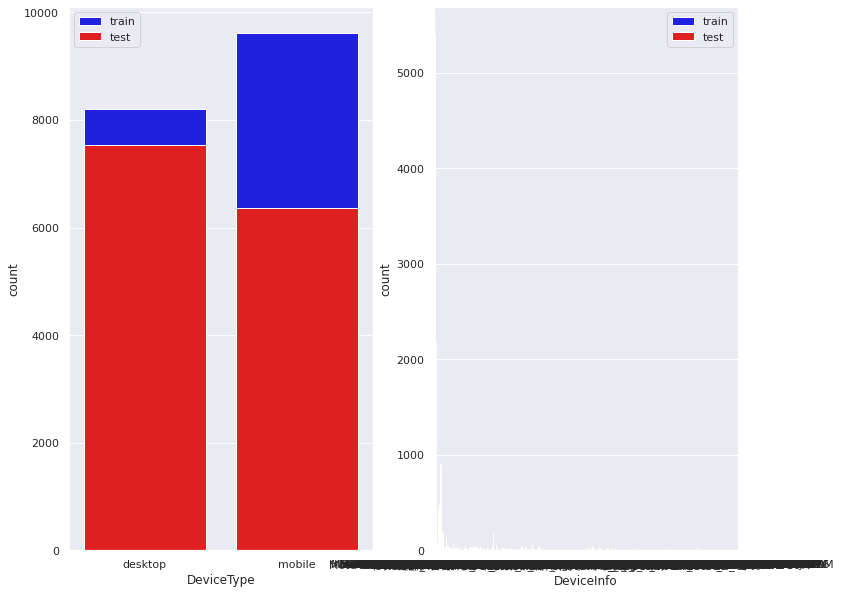

In [79]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
sns.countplot(X_train_sample['DeviceType'], color='blue', ax=ax[0], label='train')
sns.countplot(X_test_sample['DeviceType'], color='red', ax=ax[0], label='test')
ax[0].legend()
sns.countplot(X_train_sample['DeviceInfo'], color='blue', ax=ax[1], label='train')
sns.countplot(X_test_sample['DeviceInfo'], color='red', ax=ax[1], label='test')
ax[1].legend()
plt.show()

# Statistical testing

In [123]:
types = {'TransactionAmt': 'float32',
         'TransactionDT': 'int32',
         'ProductCD': 'category',
         'addr1': 'float32',
         'addr2': 'category',
         'dist1': 'float32',
         'dist2': 'float32',
         'P_emaildomain': 'category',
         'R_emaildomain': 'category',
         'card1': 'float32',
         'card2': 'float32',
         'card3': 'category',
         'card4': 'category',
         'card5': 'category',
         'card6': 'category',
         'isFraud': 'category'}

types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({f'V{i}': 'float32' for i in range(1, 340)})
types.update({(f'id_0{i}' if i<10 else f'id_{i}'): 'float32' for i in range(1, 12)})
types.update({f'id_{i}': 'category' for i in range(12, 39)})
types.update({'DeviceType': 'category', 'DeviceInfo': 'category'})

In [124]:
X_train_sample = pandas.read_csv('./data/X_train_sample.csv', header=0, dtype=types).set_index('TransactionID')
X_test_sample = pandas.read_csv('./data/X_test_sample.csv', header=0, dtype=types).set_index('TransactionID')

In [125]:
X_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 2987203 to 3560507
Columns: 433 entries, isFraud to DeviceInfo
dtypes: category(47), float32(385), int32(1)
memory usage: 75.2 MB


In [126]:
X_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50669 entries, 3663571 to 4158873
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: category(46), float32(385), int32(1)
memory usage: 77.6 MB


In [127]:
y = X_train_sample['isFraud']
X_train_sample.drop(columns=['isFraud'], inplace=True)

In [128]:
categorical = X_train_sample.select_dtypes(include=['category']).columns
numerical = X_train_sample.select_dtypes(include=['float32', 'int32']).columns

In [129]:
for feature in numerical:
    statistic, p_val = ttest_ind(X_train_sample[feature], X_test_sample[feature])
    if p_val < 0.1:
        print(feature, p_val)

TransactionDT 0.0
TransactionAmt 1.1875112369639068e-05
card1 4.658726464601318e-12


In [132]:
for feature in categorical:
    
    v1 = X_train_sample[feature].cat.categories.values
    v2 = X_test_sample[feature].cat.categories.values
    labels = {k: v for k, v in zip(v1, range(1, len(v1)+1))}
    X_train_sample[feature] = X_train_sample[feature].apply(lambda x: labels[x]).astype('category')
    labels.update({k: len(labels)+1 for k in v2 if k not in v1})
    X_test_sample[feature] = X_test_sample[feature].apply(lambda x: labels[x]).astype('category')
    test = X_test_sample[feature]
    statistic, p_val = chisquare(X_train_sample[feature],test.iloc[0:49157])
    if p_val < 0.1:
        print(feature, p_val)

ProductCD 0.0
